In [1]:
import sys
sys.path.append('..')
# modes for challenge
from src.berry import Berry
from src.simulation import BerryTransitionModel


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

from sklearn import metrics

from sklearn import linear_model 
from sklearn.preprocessing import StandardScaler

import pymc3 as pm
import theano.tensor as tt
from skopt import gp_minimize
from skopt.plots import plot_objective
from multiprocessing import Pool

import pickle

%load_ext autoreload
%autoreload 2
%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# functions needed for later
def laged_features(data, max_laggs):
    df = data.copy()
    for col in df.columns:
        for l in range(1, max_laggs):
            df.loc[:,f'{col}_lag_{l}'] = df[col].shift(l)
    return df

# Load data

In [3]:
# load count data
counts_df = pd.read_csv('../data/count_data.csv')
counts_df['date'] = pd.to_datetime(counts_df['date'])
# do days since
counts_df['days_since_start'] = (counts_df['date'] -counts_df['date'].min()).dt.days
counts_df

,week,green,colour_break_1,colour_break_2,pink,cherry,blue,year,date,days_since_start
0,39,660,327,65,19,29,54,2018,2018-09-27,0
1,40,600,292,65,18,23,109,2018,2018-10-01,4
2,41,532,240,85,25,18,65,2018,2018-10-08,11
3,43,415,162,57,17,15,40,2018,2018-10-22,25
4,44,468,125,49,12,13,18,2018,2018-10-29,32
5,45,490,121,41,12,10,20,2018,2018-11-05,39
6,46,502,105,32,9,7,22,2018,2018-11-12,46
7,48,555,137,26,9,5,10,2018,2018-11-26,60
8,49,654,150,30,7,4,4,2018,2018-12-03,67
9,50,662,155,26,6,6,16,2018,2018-12-10,74


In [4]:
# load weight data
weight_df = pd.read_csv('../data/weight_data.csv')
#weight_df['date'] = pd.to_datetime(weight_df['date'])
weight_df

,week,weight
0,39,1.74
1,40,1.63
2,41,1.78
3,43,1.54
4,44,1.50
5,45,1.42
6,46,1.41
7,48,1.61
8,49,1.52
9,50,1.71


# Data Analyisis

In [5]:
counts_df.corr()

,week,green,colour_break_1,colour_break_2,pink,cherry,blue,year,days_since_start
week,1.000000,0.070007,-0.713879,0.000372,0.139954,0.030396,-0.079987,-0.982233,-0.713403
green,0.070007,1.000000,-0.145797,-0.165221,-0.228919,-0.218414,0.008653,-0.087530,-0.122015
colour_break_1,-0.713879,-0.145797,1.000000,0.373825,0.293692,0.521233,0.467702,0.662044,0.369358
colour_break_2,0.000372,-0.165221,0.373825,1.000000,0.957840,0.821891,0.713786,-0.145895,-0.542913
pink,0.139954,-0.228919,0.293692,0.957840,1.000000,0.822568,0.662796,-0.283869,-0.645172
cherry,0.030396,-0.218414,0.521233,0.821891,0.822568,1.000000,0.747180,-0.168711,-0.532986
blue,-0.079987,0.008653,0.467702,0.713786,0.662796,0.747180,1.000000,-0.045521,-0.406298
year,-0.982233,-0.087530,0.662044,-0.145895,-0.283869,-0.168711,-0.045521,1.000000,0.832204
days_since_start,-0.713403,-0.122015,0.369358,-0.542913,-0.645172,-0.532986,-0.406298,0.832204,1.000000


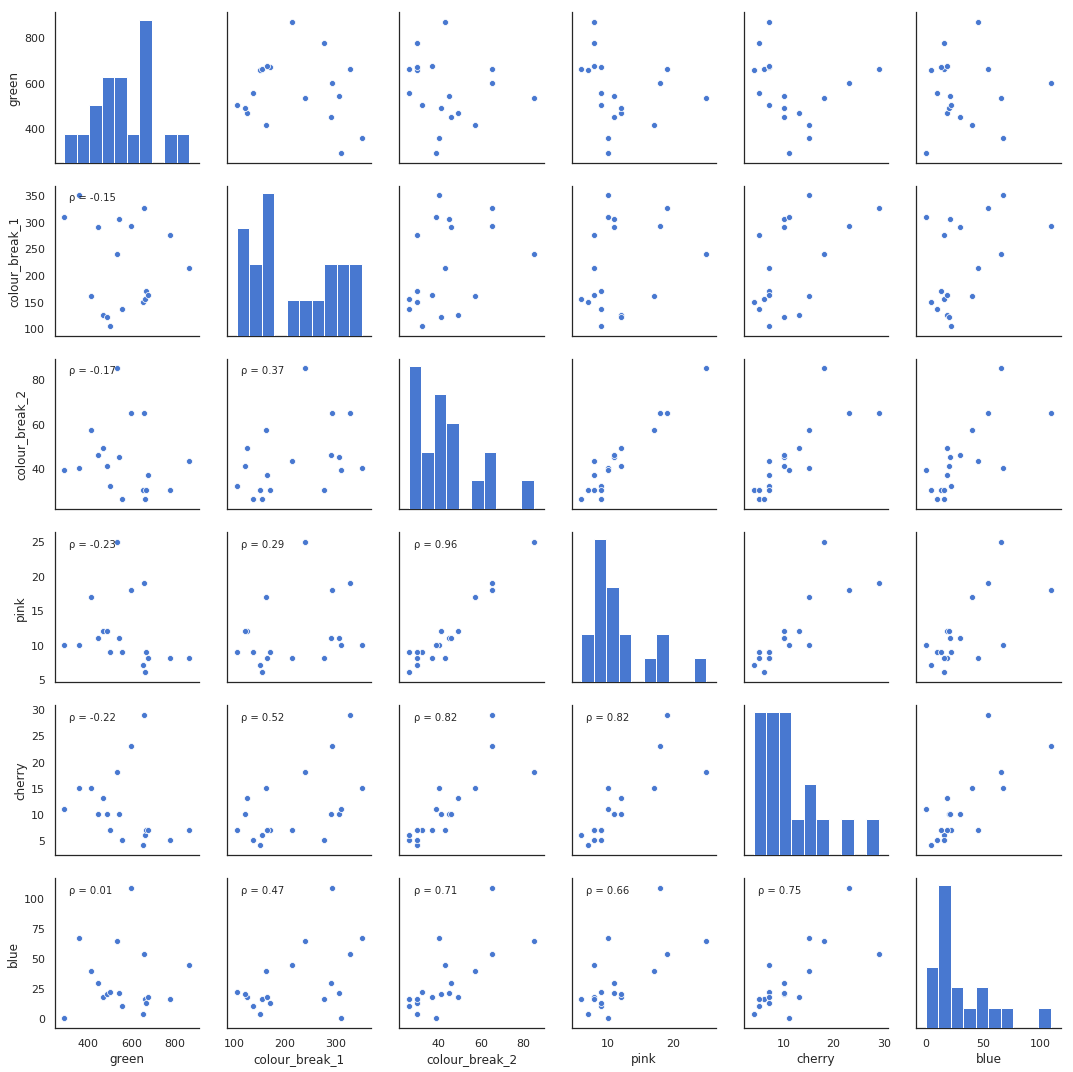

In [6]:
# plot correlations

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g = sns.pairplot(counts_df[['green','colour_break_1','colour_break_2','pink','cherry','blue']])
g.map_lower(corrfunc)

Seems like color_break_2, pink, cherry, and blue are highly correlated with eachother while green and color_break_1  weakly correlated 

## look at lagged windows to see if lagged correlation

In [7]:
# resample so steps are even
resampled_counts_df = counts_df.iloc[1:].set_index('date').resample('W-MON').interpolate('spline',order=1)
# drop last period since after observation window
resampled_counts_df =resampled_counts_df.round().iloc[:-1]

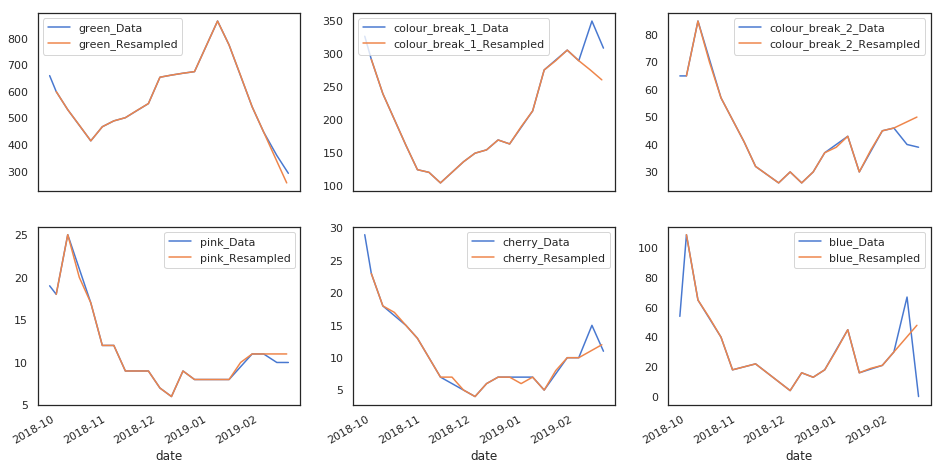

In [8]:
# plot
fig, *ax = plt.subplots(2,3, figsize=(16,8),sharex=True)
ax =np.ravel(ax)
for i, col in enumerate(['green','colour_break_1','colour_break_2','pink','cherry','blue']):
    counts_df.plot(x='date',y=col,ax=ax[i])
    resampled_counts_df[col].plot(ax=ax[i])
    ax[i].legend((f'{col}_Data', f'{col}_Resampled'))

In [9]:
# create lagged array
col = ['green', 'colour_break_1', 'colour_break_2', 'pink', 'cherry', 'blue']
lagged_df = laged_features(resampled_counts_df[col],5)
#lagged_df = lagged_df.drop(columns=['blue'])
lagged_df.corr()

,green,colour_break_1,colour_break_2,pink,cherry,blue,green_lag_1,green_lag_2,green_lag_3,green_lag_4,...,pink_lag_3,pink_lag_4,cherry_lag_1,cherry_lag_2,cherry_lag_3,cherry_lag_4,blue_lag_1,blue_lag_2,blue_lag_3,blue_lag_4
green,1.000000,-0.034870,-0.367661,-0.393205,-0.446435,-0.174256,0.875739,0.570332,0.191414,-0.162862,...,-0.468689,-0.361094,-0.535466,-0.534486,-0.493304,-0.348414,-0.256621,-0.343711,-0.412723,-0.412406
colour_break_1,-0.034870,1.000000,0.381960,0.239350,0.337430,0.462070,0.349824,0.682057,0.858594,0.881089,...,-0.565075,-0.686649,-0.006319,-0.306776,-0.516388,-0.666660,0.223393,-0.006556,-0.208796,-0.388131
colour_break_2,-0.367661,0.381960,1.000000,0.942826,0.900157,0.787170,-0.252480,-0.038904,0.382616,0.725765,...,0.325706,-0.089794,0.896713,0.734332,0.395781,-0.028829,0.880916,0.773499,0.578966,0.315878
pink,-0.393205,0.239350,0.942826,1.000000,0.888913,0.710816,-0.277323,-0.147468,0.114720,0.438565,...,0.575492,0.359912,0.940774,0.853382,0.710634,0.392073,0.901045,0.890752,0.838951,0.586294
cherry,-0.446435,0.337430,0.900157,0.888913,1.000000,0.867396,-0.437345,-0.204699,0.155718,0.494760,...,0.557104,0.195416,0.925776,0.807013,0.604400,0.269413,0.805600,0.788423,0.710266,0.571578
blue,-0.174256,0.462070,0.787170,0.710816,0.867396,1.000000,-0.184482,-0.046021,0.263871,0.574804,...,0.000611,-0.308530,0.710898,0.498646,0.154424,-0.322133,0.789626,0.504781,0.177810,-0.138057
green_lag_1,0.875739,0.349824,-0.252480,-0.277323,-0.437345,-0.184482,1.000000,0.848725,0.515514,0.152601,...,-0.626333,-0.553079,-0.458172,-0.580750,-0.604153,-0.561572,-0.110784,-0.246629,-0.391724,-0.527710
green_lag_2,0.570332,0.682057,-0.038904,-0.147468,-0.204699,-0.046021,0.848725,1.000000,0.836975,0.515391,...,-0.661848,-0.698384,-0.412547,-0.477720,-0.630646,-0.658171,-0.069312,-0.083362,-0.269212,-0.471750
green_lag_3,0.191414,0.858594,0.382616,0.114720,0.155718,0.263871,0.515514,0.836975,1.000000,0.843465,...,-0.539775,-0.696968,-0.152180,-0.399501,-0.494759,-0.654071,0.077261,-0.013738,-0.086353,-0.307660
green_lag_4,-0.162862,0.881089,0.725765,0.438565,0.494760,0.574804,0.152601,0.515391,0.843465,1.000000,...,-0.321708,-0.546471,0.203030,-0.134898,-0.395882,-0.496854,0.373012,0.117879,-0.005070,-0.097846


Seems like green and color_break_1 have correlation after a few weeks

# Model

This approached models the berry as an agent with an age and a ripening stage that progresses through the stages. The parametes that will be optimized are the initial conditions for the age distribution of each state, the number of new berries coming into the green state, and the amount of berries lost at each stage.

In [10]:
# example of berry agent
berry = Berry(0)
for day in range(63):
    print(berry.step(day,0.))
    
# terminal states
print(berry.pick())
print(Berry(0).loose())

State: "green" stage age: 1 total age: 1 transition times:{'green': 21, 'colour_break_1': 18, 'colour_break_2': 11, 'pink': 5, 'cherry': 3, 'blue': 0}
State: "green" stage age: 2 total age: 2 transition times:{'green': 21, 'colour_break_1': 18, 'colour_break_2': 11, 'pink': 5, 'cherry': 3, 'blue': 0}
State: "green" stage age: 3 total age: 3 transition times:{'green': 21, 'colour_break_1': 18, 'colour_break_2': 11, 'pink': 5, 'cherry': 3, 'blue': 0}
State: "green" stage age: 4 total age: 4 transition times:{'green': 21, 'colour_break_1': 18, 'colour_break_2': 11, 'pink': 5, 'cherry': 3, 'blue': 0}
State: "green" stage age: 5 total age: 5 transition times:{'green': 21, 'colour_break_1': 18, 'colour_break_2': 11, 'pink': 5, 'cherry': 3, 'blue': 0}
State: "green" stage age: 6 total age: 6 transition times:{'green': 21, 'colour_break_1': 18, 'colour_break_2': 11, 'pink': 5, 'cherry': 3, 'blue': 0}
State: "green" stage age: 7 total age: 7 transition times:{'green': 21, 'colour_break_1': 18, 

In [11]:
# set initial berries
init_params = dict()
init_params.update(counts_df[['green', 'colour_break_1', 'colour_break_2', 'pink', 'cherry', 'blue']].iloc[0].to_dict())
init_params

{'green': 660,
 'colour_break_1': 327,
 'colour_break_2': 65,
 'pink': 19,
 'cherry': 29,
 'blue': 54}

In [12]:
# param ranges
param_list = [(0,21.), (0,18.), (0,11.),(0,5.), (0,3.), # mean age rages
             (0.001,40), (0.0001,40), (0.001,20),(0.001,10), (0.001,10), # std transition time
              (0,.8), (0,.8), (0,.6),(0,.6), (0,.6),(0,.0001), # loss proportions
             (10,200)] # new berry param


In [13]:
# save best run for later 1.38
param_best = [21.0,
 3.921585873422145,
 8.140576965697154,
 1.0038450940558172,
 0.13452969554956307,
 40.0,
 19.67543660075501,
 5.355616387222723,
 3.426711562106714,
 6.810059118034917,
 0.0,
 0.8,
 0.027516460635882832,
 0.35048980290874066,
 0.1308964993716192,
 6.0173957851108774e-05,
 20]


In [ ]:
# fit to data
agent_model = BerryTransitionModel(y_df=counts_df,**init_params)
out = gp_minimize(agent_model.minimize,param_list,n_calls=200,verbose=True,n_jobs=7,x0=param_best)
# best param
out.x,out.fun

Iteration No: 1 started. Evaluating function at provided point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 3.4370
Function value obtained: 2.2359
Current minimum: 2.2359
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.1639
Function value obtained: 706.6570
Current minimum: 2.2359
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 16.4809
Function value obtained: 246.6213
Current minimum: 2.2359
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 5.6949
Function value obtained: 42.5906
Current minimum: 2.2359
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.6379
Function value obtained: 789.2186
Current minimum: 2.2359
Iteration No: 6 start

In [ ]:
gp = np.asarray(out.models)[out.func_vals.argsort()[0]]
gp.predict(out.space.rvs())

In [ ]:
# plot param space
# get param names
param_names= agent_model.unwrap(param_best)

names =[]
for p in ['mu__init', 'sigma__init','loss']:
    for states in param_names:
        if p not in param_names[states]:
            continue
        names.append('{}_{}'.format(states, p))
names.append("new berry lambda")
plot_objective(out,sample_source='expected_minimum',dimensions=names);

In [ ]:
# plot results
param_best = out.x
param_best[-1] = 20
inx = counts_df.set_index('days_since_start').index
fig, ax = plt.subplots()
_,results_df = agent_model.evaluate(counts_df.set_index('days_since_start').index.values, *out.x, pick=True)
results_df = pd.DataFrame(results_df)

results_df.loc[inx].plot(x='global_age', y='blue',ax=ax)
counts_df.plot(x='days_since_start', y='blue',ax=ax)
ax.set_ylabel('Blue berry count')
plt.legend(('Model','Data'))

print('MSE on Blue berry count is {}'.format(metrics.mean_squared_error(counts_df.set_index('days_since_start').blue, results_df.set_index('global_age').loc[inx].blue)))
results_df.set_index('global_age').loc[inx]

In [ ]:
agent_model.unwrap(out.x)

# Model weight

In [ ]:
# add days since start

weight_df = pd.merge(weight_df, counts_df[['week', 'days_since_start']],on=['week'])
weight_df

In [ ]:
# do simple linear fit
def polyval_curve_fit(x,*p):
    return np.polyval(p,x)
weight_out = curve_fit(polyval_curve_fit,weight_df.days_since_start, weight_df.weight, [0.]*2)
weight_out
mse = metrics.mean_squared_error(weight_df.weight,polyval_curve_fit(weight_df.days_since_start,*weight_out[0]))
print('MSE is {:.3f}'.format(mse))
weight_out

In [ ]:
weight_df.plot(x='days_since_start', y='weight',kind='scatter',c='r')
plt.plot(weight_df.days_since_start, polyval_curve_fit(weight_df.days_since_start,*weight_out[0]))
plt.legend(('Data', 'Model'))

# Yield Estimation

In [ ]:
n_samples = 100

In [ ]:
# get days since start of forecast period
forecast_period = np.asarray([fp for fp in range(max(counts_df.days_since_start)+7, max(counts_df.days_since_start)+1+7*4,7)])
forecast_period

In [ ]:
# sample weight params to get estimation uncertanty
weights = [polyval_curve_fit(x,*p) for x,p in zip([forecast_period]*n_samples, stats.multivariate_normal(weight_out[0], weight_out[1]).rvs(n_samples))]
np.vstack(weights).mean(0)
np.vstack(weights).std(0)

In [ ]:
# run multiple realizations to get future berries
days_since = np.append(counts_df.days_since_start.values, forecast_period)

forecasted_berry_count = []
for _ in range(n_samples):
    result_df = pd.DataFrame(agent_model.evaluate(days_since, *param_best, pick=False)[0]).set_index('global_age')
    # calculate the change from last observerd 
    last_obs_blue = result_df.loc[145,'blue']
    forecasted_berry_count.append(result_df.loc[forecast_period, 'blue'] - last_obs_blue)

In [ ]:
# calculate yield with uncertanty
cumulative_yeilds = []
for i in range(n_samples):
    # turn to kg
    cumulative_yeilds.append(weights[i] * forecasted_berry_count[i].values/1000.)
cumulative_yeilds[0]   

In [ ]:
# cumlative yield
plt.errorbar(range(9,13), np.mean(cumulative_yeilds,0),yerr=np.std(cumulative_yeilds,0))
plt.ylabel('Cumulative Yield (Kg of blueberries)')
plt.xlabel('2019 Week')
np.mean(cumulative_yeilds,0), np.std(cumulative_yeilds,0)

In [ ]:
# cumlative yield
plt.errorbar(range(9,12), np.mean(np.diff(cumulative_yeilds),0),yerr=np.std(np.diff(cumulative_yeilds),0))
plt.ylabel('Kg berries')
plt.xlabel('2019 Week')